# Face Detection and Recognition CNN Models

Author: Luca Franceschi (u199149)

In this notebook we will try to construct two CNN models, one for face boundary detection and another for face recognition. The intention for the Coding Challenge 3 is to: with each image first detect if there is a face or not, in case there is, detect the boundaries. Then we can crop the image with the calculated boundaries and pass it to the recognition model to be able to recognize if the face exists in the dataset or is an impostor.

In [1]:
import torch
import scipy.io
import torch.jit
import numpy as np
from torch import nn
from PIL import Image
import torch.optim as optim
from matplotlib import ticker
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import cv2

from torch.utils.data import random_split
from torchvision.transforms.functional import get_image_size

In [2]:
# Hyperparameters
lr = 0.0001                 # Learning rate
epochs1 = 45                # Total number of epochs
epochs2 = 20
batch_size = 32             # The sizes in which the dataset is split to feed the networks
det_resized = (224, 224)    # The normalized size of the images in the detection model
rec_resized = det_resized   # The normalized size of the images in the recognition model

# Other parameters
epoch_step = 1              # Frequency in which epoch losses are printed on training
images_path = './TRAINING/' # Relativ# train_mean, train_std = compute_mean_std(det_train_data)e path to the training dataset
target_matrix_path = ''     # Relative path to the "AGC_Challenge3_Training.mat" file
identities = 80

In [3]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Loading the data

### The target matrix

When loading the matrix we can import either the boundaries or the identity. 
- For the detection network we will import the Image name along with the boundaries. In case there is a face (or more) the first position in the boundaries will be the amount of faces in that image. In case there is no faces, that parameter will be 0 and the boundaries will be a "padding" of zeros. The imported data in this case will look like: ```[name, [#faces, x0, y0, x1, y1]]```, very similar as in previous labs. In case there are more than one face the first one in the matrix will be considered.
- For the recognition network we will import the image name along with the id and its boundaries. If the id is -1 it is imported as 0 to fix some out of bounds error. This is corrected in the output of the model and is transparent to the user.

In [50]:
def load_data(labels_path, labels_wanted='boundaries'):
    mat = scipy.io.loadmat(labels_path)['AGC_Challenge3_TRAINING'][0]
    data = []
    # counter = 0
    # impostors = 0
    for entry in mat:
        key = entry[1][0]
        if (len(entry[2]) > 0):
            boundary = np.array(entry[2][0], dtype=np.int32)
            if (labels_wanted == 'boundaries'):
                data.append([key, boundary])
            elif (labels_wanted == 'identity'):
                if (entry[0][0][0] == -1):
                    # if (impostors < counter / identities):
                    data.append([key, 0, boundary])
                        # impostors += 1
                else:
                    data.append([key, entry[0][0][0], boundary])
                    # counter += 1

    return data

In [51]:
detection_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat')
recognition_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat', 'identity')

### Computing the mean and standard deviation

In [6]:
def compute_mean_std(dataset):
    image_count = len(dataset)
    images = np.zeros((image_count, rec_resized[0], rec_resized[1], 3))
    for i, (image_path, _) in enumerate(dataset):
        with Image.open(images_path + image_path) as image:
            image = image.resize(det_resized)
            image = image.convert('RGB')
            image_array = np.array(image)
            images[i] = image_array

    mean = np.mean(images, axis=(0, 1, 2)) / 255.0
    std_dev = np.std(images, axis=(0, 1, 2)) / 255.0

    return mean, std_dev

In [7]:
m, s = compute_mean_std(detection_data)

# data_mean = [0.485, 0.456, 0.406]
# data_std = [0.229, 0.224, 0.225]

data_mean = m
data_std = s

print(data_mean, data_std)

[0.48464295 0.4219926  0.39299254] [0.32095764 0.30016821 0.29993387]


## The Transforms

In [8]:
det_tr_transform = transforms.Compose([
    # transforms.Resize(300, 300),
    transforms.RandomResizedCrop(det_resized),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_mean, std=train_std)
    transforms.Normalize(mean=data_mean, std=data_std)
])

det_base_transform = transforms.Compose([
    transforms.Resize(det_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_tr_transform = transforms.Compose([
    transforms.RandomResizedCrop(rec_resized),
    transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(180),
    transforms.RandomGrayscale(0.2),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.RandomAffine(90),
    transforms.AutoAugment(),
    ## scaling shearing affine
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_val_transform = transforms.Compose([
    transforms.Resize(rec_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

### Early stopper

In [9]:
class EarlyStopper: # used in classification problem
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
        return self.counter

## The Convolutional Neural Network Class

In [10]:
class CNN(nn.Module):
    def __init__(self, cnn_layers, fc_layers, type):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = cnn_layers
        self.fc_layers = fc_layers
        self.cnn_type = type

    def forward(self, data):
        output = self.cnn_layers(data)
        output = self.flatten(output) # before linear layer !!!
        output = self.fc_layers(output)
        return output

    def fit(self, training_data, loss_fn, optimizer: optim.Optimizer):
        self.train()
        total_loss = 0.0

        for batch_data, target in training_data:
            batch_data = batch_data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = self.forward(batch_data)
            
            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                target = target.type(torch.long)

            loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(training_data)

    def evaluate(self, validation_data, loss_fn):
        self.eval()
        total_loss = 0.0

        for batch_data, target in validation_data:
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            output = self.forward(batch_data)

            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                target = target.type(torch.long)

            loss = loss_fn(output, target)

            total_loss += loss.item()

            # Compute accuracy
            # _, predicted = torch.max(output, 1)
            # total_predictions += labels.size(0)
            # correct_predictions += (predicted == labels).sum().item()

        # average_loss = total_loss / len(validation_data)
        # accuracy = correct_predictions / total_predictions

        return total_loss / len(validation_data)

    def predict(self, test_image):
        self.eval()
        with torch.inference_mode(mode=True):
            test_image = test_image.convert('RGB')
            w, h = get_image_size(test_image)
            if self.cnn_type == 'detection':
                test_image = det_base_transform(test_image)
                # test_image = torch.tensor(test_image, dtype=torch.float32)
                output = self.forward(test_image.unsqueeze(0))[0]
                # print(output)
                # output = [output[0], output[1]*w/det_resized[0], output[2]*h/det_resized[1], output[3]*w/det_resized[0], output[4]*h/det_resized[1]]
                output = [output[0]*w/det_resized[0], output[1]*h/det_resized[1], output[2]*w/det_resized[0], output[3]*h/det_resized[1]]
                # print(output)
                return output
            elif self.cnn_type == 'recognition':
                test_image = rec_val_transform(test_image)
                output = self.forward(test_image.unsqueeze(0))
                output = torch.softmax(output, 1)
                output = np.argmax(output)
                if output == 0:
                    return -1
                return int(output)

    def training_loop(self, training_loader, val_loader, epochs, loss_fn, lr):
        tr_losses = []
        val_losses = []
        optimizer = optim.Adam(self.parameters(), lr=lr)
        best_weights = self.state_dict().copy()
        if self.cnn_type == 'detection':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs')

        early_stopper = EarlyStopper(patience=3, min_delta=0.01)

        for epoch in range(epochs):
            tr_losses.append(self.fit(training_loader, loss_fn, optimizer))
            loss = self.evaluate(val_loader, loss_fn)
            val_losses.append(loss)
            if self.cnn_type == 'detection':
                scheduler.step(loss)

            stopper = early_stopper.early_stop(loss)
            if stopper == 0:
                best_weights = self.state_dict().copy()
            elif stopper > early_stopper.patience:
                self.load_state_dict(best_weights)
                break

            if epoch % epoch_step == 0:
                print(f'Epoch {epoch} has loss {val_losses[epoch]}')
        
        return tr_losses, val_losses

## The Detection Model

### DataLoader

In [11]:
class DetectionData(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        with Image.open(images_path + image_name) as image:
            # Apply transformations if specified
            image = image.convert('RGB')
            w, h = get_image_size(image)
            if self.transform:
                image = self.transform(image)
            # image = torch.tensor(image, dtype=torch.float32)

            # label = [label[0], label[1]/w*det_resized[0], label[2]/h*det_resized[1], label[3]/w*det_resized[0], label[4]/h*det_resized[1]]
            label = [label[0]/w*det_resized[0], label[1]/h*det_resized[1], label[2]/w*det_resized[0], label[3]/h*det_resized[1]]
            label = torch.tensor(label, dtype=torch.float32)
            label = torch.flatten(label)
            return image, label

In [12]:
det_train_data, det_val_data, det_test_data = random_split(detection_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset = DetectionData(det_train_data, det_tr_transform)
val_dataset = DetectionData(det_val_data, det_base_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### Layers

In [13]:
detection_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
detection_fc_layers = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(25088, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(32, 4)
)

### Training

In [14]:
detection = CNN(detection_cnn_layers, detection_fc_layers, 'detection').to(device)
summary(detection, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 4]                   --
├─Sequential: 1-1                        [32, 128, 14, 14]         --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 224, 224]        32
│    └─ReLU: 2-3                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 16, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 32, 112, 112]        4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 112, 112]        64
│    └─ReLU: 2-7                         [32, 32, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 32, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 64, 56, 56]          18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 56, 56]          128
│    └─ReLU: 2-11                        [32, 64, 56, 56]          --
│    └

In [15]:
# detection.load_state_dict(torch.load('detection_model.pt'))

In [16]:
print(sum(p.numel() for p in detection.parameters()))

900900


In [17]:
loss = nn.MSELoss()
det_tr_losses, det_val_losses = detection.training_loop(train_loader, val_loader, epochs1, loss, lr)

Epoch 0 has loss 10720.84033203125
Epoch 1 has loss 6819.497802734375
Epoch 2 has loss 4001.9500732421875
Epoch 3 has loss 2634.777587890625
Epoch 4 has loss 2027.3062744140625
Epoch 5 has loss 1596.1464233398438
Epoch 6 has loss 1413.0736694335938
Epoch 7 has loss 1238.1102294921875
Epoch 8 has loss 1247.3487548828125
Epoch 9 has loss 1024.6934204101562
Epoch 10 has loss 1002.2584533691406
Epoch 11 has loss 1065.5952453613281
Epoch 12 has loss 1119.2068481445312
Epoch 13 has loss 1066.9091796875
Epoch 14 has loss 897.9016723632812
Epoch 15 has loss 895.4917907714844
Epoch 16 has loss 941.74169921875
Epoch 17 has loss 848.3461303710938
Epoch 18 has loss 915.0456848144531
Epoch 19 has loss 828.2999877929688
Epoch 20 has loss 881.6428833007812
Epoch 21 has loss 832.1694641113281
Epoch 22 has loss 817.802978515625
Epoch 23 has loss 802.5525512695312
Epoch 24 has loss 837.9571838378906
Epoch 25 has loss 869.324462890625
Epoch 26 has loss 841.3306274414062


### Plots

In [18]:
def loss_epoch_plot(losses, title='Loss vs training epochs', nbins='auto'):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins, integer=True))
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    x = np.linspace(1, len(losses)+1, len(losses), dtype=np.uint16)
    plt.plot(x, losses)
    
    plt.show()

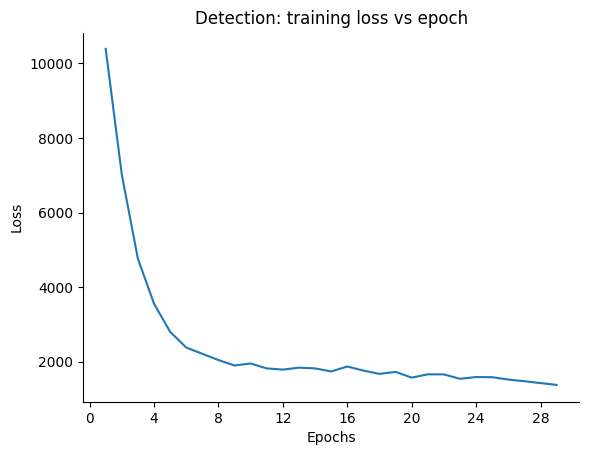

In [45]:
loss_epoch_plot(det_tr_losses, "Detection: training loss vs epoch")

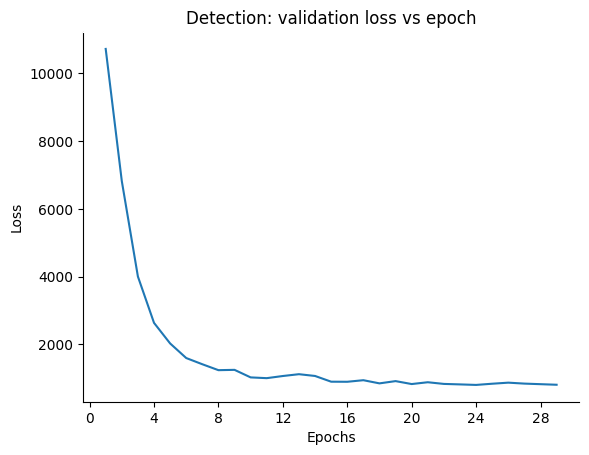

In [42]:
loss_epoch_plot(det_val_losses, "Detection: validation loss vs epoch")

### Testing

[ 42 208 430 596]


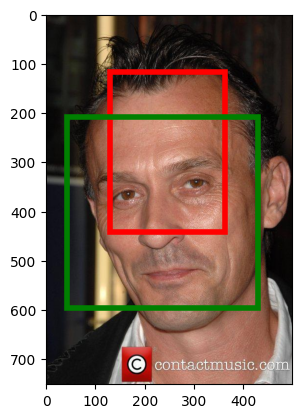

[153  65 339 251]


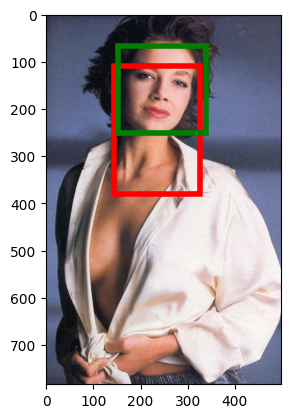

[378 118 691 431]


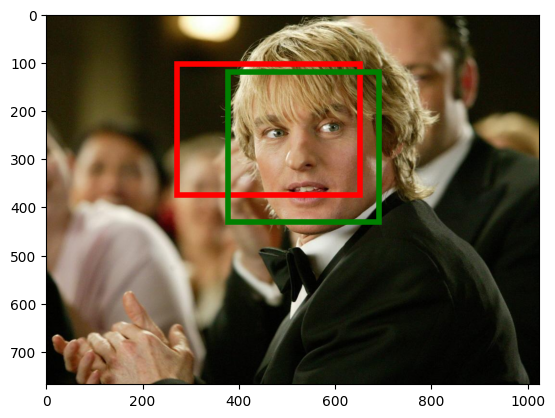

[ 96  18 199 121]


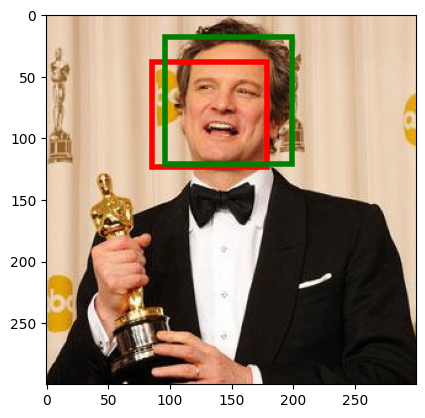

[218 303 548 633]


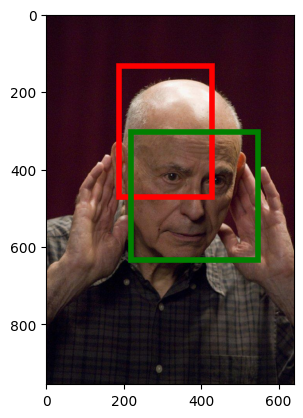

[218  88 352 222]


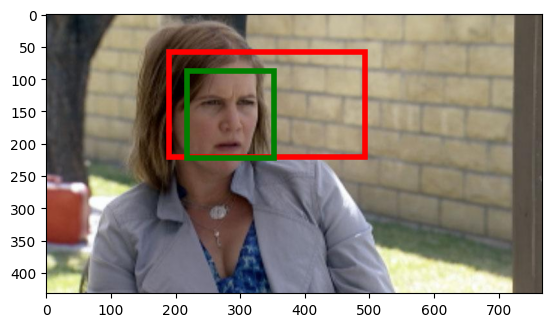

In [21]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        print(target)
        output = detection.predict(image)
        pred_fb = patches.Rectangle((output[0], output[1]), output[2]-output[0], output[3]-output[1],
                               linewidth=4, edgecolor='red', facecolor='none')
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1],
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(pred_fb)
        ax.add_patch(fb)
        plt.show()

### Saving

In [22]:
torch.save(detection.state_dict(), 'detection_model.pt')

## The Detection Model 2 (Viola-Jones)

In [23]:
path_to_cv2_model = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
cv2_detector = cv2.CascadeClassifier(path_to_cv2_model)
#concatenado de modelos

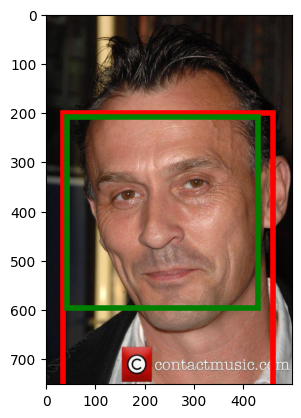

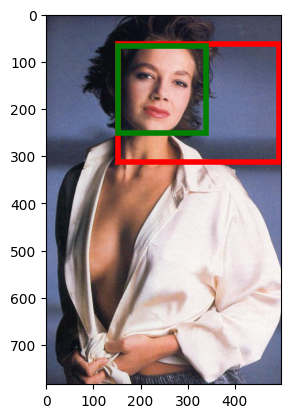

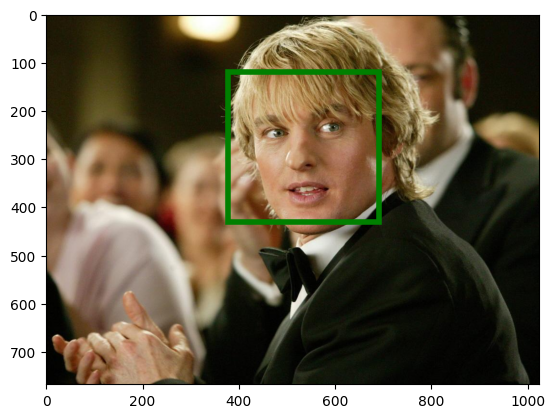

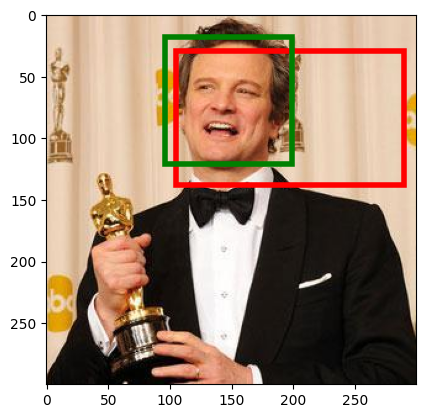

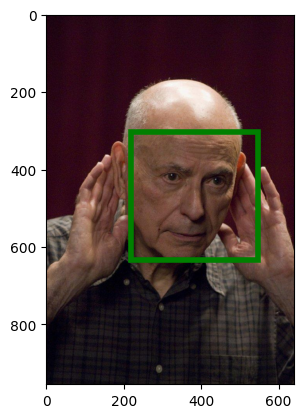

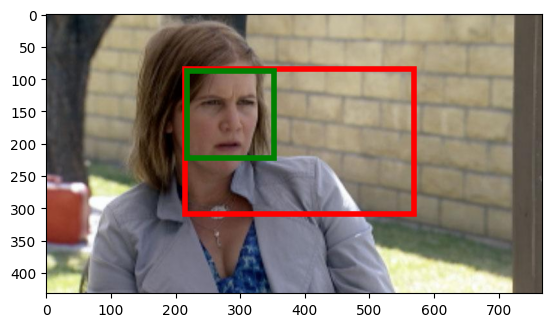

In [24]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        
        output = cv2_detector.detectMultiScale(  np.array(image),
                                        scaleFactor=1.25,
                                        minNeighbors=4,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
        if len(output) == 1:
            output = output[0]
        
        if len(output) == 4:
            pred_fb = patches.Rectangle((output[0], output[1]), output[2]+output[0], output[3]+output[1],
                               linewidth=4, edgecolor='red', facecolor='none')
            ax.add_patch(pred_fb)
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1],
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(fb)
        plt.show()

## The Recognition model

### DataLoader

In [25]:
class RecognitionData(Dataset):
    # the data is in the form [img_name, identity]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, id, boundary = self.data[idx]
        with Image.open(images_path + image_name) as image:
            image = image.convert('RGB')
            image = image.crop(boundary)
            if self.transform:
                image = self.transform(image)
            id = torch.tensor(id, dtype=torch.float32)
            return image, id

In [26]:
rec_train_data, rec_val_data, rec_test_data = random_split(recognition_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset2 = RecognitionData(rec_train_data, rec_tr_transform)
val_dataset2 = RecognitionData(rec_val_data, rec_val_transform)

# sampler = WeightedRandomSampler(class_weights_inv, len(train_dataset2), replacement=True)
# train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, sampler=sampler)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size)

### Class weighting

In [27]:
def get_class_weights(data, classes):
    ids = [entry[1] for entry in data]
    fig, ax = plt.subplots()
    ax.hist(ids, identities)
    plt.title('Class counts histogram')
    plt.xlabel('Identity')
    plt.ylabel('Count')
    plt.yscale('log', base=2)
    plt.show()
    counters = np.bincount(ids)
    sum = np.sum(counters)
    print('Total images:', sum)
    return sum / (classes * counters)

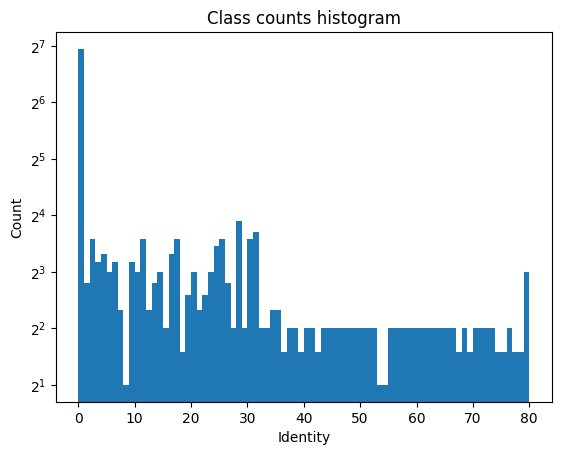

Total images: 559
Class weights: tensor([0.0568, 0.9982, 0.5823, 0.7764, 0.6988, 0.8734, 0.7764, 1.3975, 3.4938,
        0.7764, 0.8734, 0.5823, 1.3975, 0.9982, 0.8734, 1.7469, 0.6988, 0.5823,
        2.3292, 1.1646, 0.8734, 1.3975, 1.1646, 0.8734, 0.6352, 0.5823, 0.9982,
        1.7469, 0.4658, 1.7469, 0.5823, 0.5375, 1.7469, 1.7469, 1.3975, 1.3975,
        2.3292, 1.7469, 1.7469, 2.3292, 1.7469, 1.7469, 2.3292, 1.7469, 1.7469,
        1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 3.4938,
        3.4938, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469, 1.7469,
        1.7469, 1.7469, 1.7469, 1.7469, 2.3292, 1.7469, 2.3292, 1.7469, 1.7469,
        1.7469, 1.7469, 2.3292, 2.3292, 1.7469, 2.3292, 2.3292, 1.7469, 1.7469])


In [28]:
weights = get_class_weights(rec_train_data, identities) # Used for balancing classification problem
class_weights = torch.FloatTensor(weights)
print('Class weights:', class_weights)

### Layers

In [29]:
recognition_cnn_layers = nn.Sequential( # prueba al revés (empezar con numero alto de canales e ir reduciendo hasta 64 64 32 32 16 16)
    #64 64 128 128
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # prueba de dejarlo en 1 el stride (antes 2)

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2)

    # adaptivemaxpooling prueba
)
recognition_fc_layers = nn.Sequential(
    # nn.Dropout(0.2),# prueba de quitar dropout
    nn.Linear(21632, 32), # image size que no sea pequeño >12x12
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 81), # 1-80 are ids + (-1) are 81 identities
)

### Training

In [30]:
recognition = CNN(recognition_cnn_layers, recognition_fc_layers, 'recognition').to(device)
summary(recognition, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 81]                  --
├─Sequential: 1-1                        [32, 128, 13, 13]         --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 224, 224]        32
│    └─ReLU: 2-3                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 16, 111, 111]        --
│    └─Conv2d: 2-5                       [32, 32, 111, 111]        4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 111, 111]        64
│    └─ReLU: 2-7                         [32, 32, 111, 111]        --
│    └─MaxPool2d: 2-8                    [32, 32, 55, 55]          --
│    └─Conv2d: 2-9                       [32, 64, 55, 55]          18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 55, 55]          128
│    └─ReLU: 2-11                        [32, 64, 55, 55]          --
│    └

In [31]:
# recognition.load_state_dict(torch.load('recognition_model.pt'))

In [32]:
print(sum(p.numel() for p in recognition.parameters()))

792849


In [33]:
loss2 = nn.CrossEntropyLoss(class_weights)
rec_tr_losses, rec_val_losses = recognition.training_loop(train_loader2, val_loader2, epochs2, loss2, lr)

Epoch 0 has loss 4.380136489868164
Epoch 1 has loss 4.380156993865967
Epoch 2 has loss 4.380140781402588
Epoch 3 has loss 4.38020133972168
Epoch 4 has loss 4.3802080154418945
Epoch 5 has loss 4.380167007446289
Epoch 6 has loss 4.380218505859375
Epoch 7 has loss 4.380245208740234
Epoch 8 has loss 4.380285263061523
Epoch 9 has loss 4.380334377288818
Epoch 10 has loss 4.380328178405762
Epoch 11 has loss 4.380295991897583
Epoch 12 has loss 4.380300045013428
Epoch 13 has loss 4.38029932975769
Epoch 14 has loss 4.380362510681152
Epoch 15 has loss 4.380401849746704
Epoch 16 has loss 4.380324125289917
Epoch 17 has loss 4.380334377288818
Epoch 18 has loss 4.380331993103027
Epoch 19 has loss 4.380345582962036


### Plots

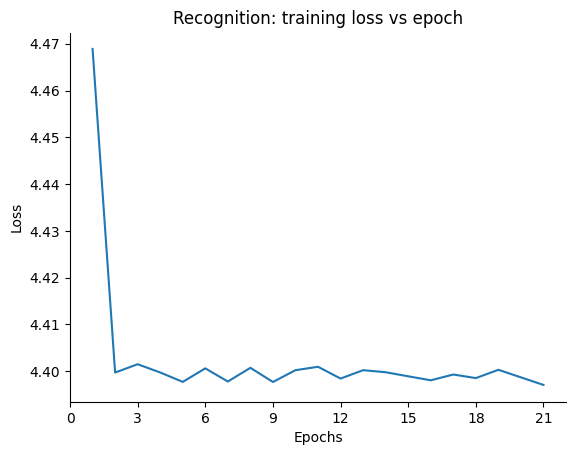

In [40]:
loss_epoch_plot(rec_tr_losses, "Recognition: training loss vs epoch")

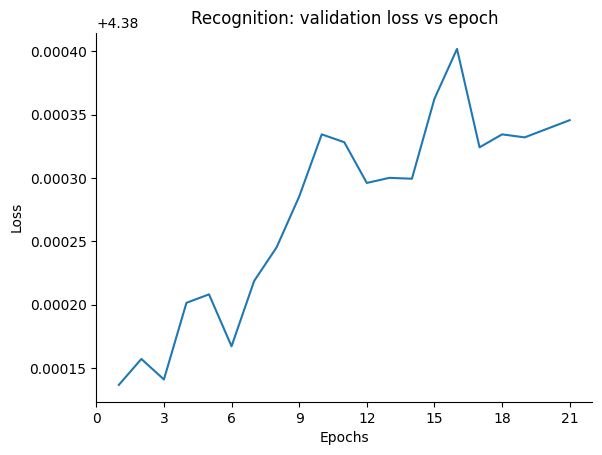

In [41]:
loss_epoch_plot(rec_val_losses, "Recognition: validation loss vs epoch")

### Testing

In [36]:
'''The function that is used to calculate the score in the file CHALL_AGC_FRbasicScript.py'''

def CHALL_AGC_ComputeRecognScores(auto_ids, true_ids):
    #   Compute face recognition score
    #
    #   INPUTS
    #     - AutomSTR: The results of the automatic face
    #     recognition algorithm, stored as an integer
    #
    #     - AGC_Challenge_STR: The ground truth ids
    #
    #   OUTPUT
    #     - FR_score:     The final recognition score
    #
    #   --------------------------------------------------------------------
    #   AGC Challenge
    #   Universitat Pompeu Fabra
    #

    if len(auto_ids) != len(true_ids):
        assert ('Inputs must be of the same len');

    f_beta = 1
    res_list = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nTP = len([i for i in res_list if auto_ids[i] == true_ids[i]])

    res_list = list(filter(lambda x: auto_ids[x] != -1, range(len(auto_ids))))

    nFP = len([i for i in res_list if auto_ids[i] != true_ids[i]])

    res_list_auto_ids = list(filter(lambda x: auto_ids[x] == -1, range(len(auto_ids))))
    res_list_true_ids = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nFN = len(set(res_list_auto_ids).intersection(res_list_true_ids))

    FR_score = (1 + f_beta ** 2) * nTP / ((1 + f_beta ** 2) * nTP + f_beta ** 2 * nFN + nFP)

    return FR_score * 100

In [37]:
predictions_count = {}
expected_count = {}
good = 0
predictions = []
expected = []

predictions_count[-1] = 0
expected_count[-1] = 0

for i in range(1, 81):
    predictions_count[i] = 0
    expected_count[i] = 0

for image_name, id, boundary in rec_train_data:
    with Image.open(images_path + image_name) as image:
        image = image.convert('RGB')
        image = image.crop(boundary)
        if id == 0:
            target = -1
        else:
            target = id
        output = recognition.predict(image)

        predictions_count[output] += 1
        expected_count[target] += 1
        predictions.append(output)
        expected.append(target)

        if output == target:
            good += 1

for key in predictions_count:
    print(f'Identity {key}: Predicted {predictions_count[key]} of {expected_count[key]}')

print('F1-score:', CHALL_AGC_ComputeRecognScores(predictions, expected))

Identity -1: Predicted 0 of 123
Identity 1: Predicted 0 of 7
Identity 2: Predicted 0 of 12
Identity 3: Predicted 0 of 9
Identity 4: Predicted 559 of 10
Identity 5: Predicted 0 of 8
Identity 6: Predicted 0 of 9
Identity 7: Predicted 0 of 5
Identity 8: Predicted 0 of 2
Identity 9: Predicted 0 of 9
Identity 10: Predicted 0 of 8
Identity 11: Predicted 0 of 12
Identity 12: Predicted 0 of 5
Identity 13: Predicted 0 of 7
Identity 14: Predicted 0 of 8
Identity 15: Predicted 0 of 4
Identity 16: Predicted 0 of 10
Identity 17: Predicted 0 of 12
Identity 18: Predicted 0 of 3
Identity 19: Predicted 0 of 6
Identity 20: Predicted 0 of 8
Identity 21: Predicted 0 of 5
Identity 22: Predicted 0 of 6
Identity 23: Predicted 0 of 8
Identity 24: Predicted 0 of 11
Identity 25: Predicted 0 of 12
Identity 26: Predicted 0 of 7
Identity 27: Predicted 0 of 4
Identity 28: Predicted 0 of 15
Identity 29: Predicted 0 of 4
Identity 30: Predicted 0 of 12
Identity 31: Predicted 0 of 13
Identity 32: Predicted 0 of 4
Ident

### Saving

In [38]:
torch.save(recognition.state_dict(), 'recognition_model.pt')